In [1]:
import random
from Bio import SeqUtils
from fish_helpers import *
from scipy.signal import lfilter
import tqdm#.notebook as tqdm
from Bio import SeqIO
from scipy import sparse
from multiprocessing import Pool
from functools import partial
import sys

In [2]:
import random
random.choice(['Semi-Pro','Talledaga Nights','Step Brothers','Anchorman'])

'Step Brothers'

In [3]:
genes = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/Allen/R_filtered_genes.csv',index_col=0)
genes.head()

,filtered_genes
1,0610009B22Rik
2,0610010K14Rik
3,0610011F06Rik
4,0610012G03Rik
5,0610037L13Rik


In [4]:
"""
Parse Transcriptome
transcript identifier (tid) (index)
gene identifier (gene)
sequence (seq)
Convert seq to int (intseq)
for each seed length region:
find each identity(hash)
find if it contains N bases(isvalid)
"""
resourcePath = '/bigstore/binfo/mouse/'
rawTranscriptomeFasta = os.path.join(resourcePath,'mer_transcripts.fa')

tids = []
gids = []
seqs = []
intSeqs = []
seed_hashs = []
probe_len = 30
seedLength = 17
nt2int = {'A':0,'C':1,'G':2,'T':3,'N':np.nan}
seedhashBase = [4**i for i in np.linspace(seedLength-1,0,seedLength)]
with open(rawTranscriptomeFasta) as fasta_file:  # Will close handle cleanly
    for seq_record in tqdm.tqdm(SeqIO.parse(fasta_file, 'fasta'),desc='Loading Transcriptome'):  # (generator)
        tid,gid = seq_record.description.split(' ')
        gid = gid.split('=')[-1]
        seq = str(seq_record.seq)
        if len(seq)>probe_len:
            intSeq = np.array([nt2int[i] for i in seq])
            seed_hash = list(lfilter(seedhashBase,1,intSeq)[seedLength-1:-1].astype(int))
            tids.append(tid)
            gids.append(gid)
            seqs.append(seq)
            intSeqs.append(intSeq)
            seed_hashs.append(seed_hash)
transcriptome = pd.DataFrame(index=tids)
transcriptome['gene'] = gids
transcriptome['seq'] = seqs
transcriptome['intseq'] = intSeqs
transcriptome['hash'] = seed_hashs

Loading Transcriptome: 125570it [02:01, 1030.15it/s]


In [5]:
"""
Load Annotation Data
"""
annotation = pd.read_csv('/bigstore/binfo/mouse/mart_export_25Nov2019.txt',sep='\t')
annotation.index = list(annotation['Transcript stable ID'])
"""
Filter Transcriptome to tsl<5
"""
tids = list(transcriptome.index)
TSL = []
for tsl in annotation['Transcript support level (TSL)']:
    try:
        TSL.append(tsl.split(' (')[0])
    except:
        TSL.append('tslNA')
keepers = np.unique(TSL)
keepers = [i for i in keepers if not i=='tslNA']
keepers = [i for i in keepers if not i=='tsl5']
mask = []
for tsl in TSL:
    if tsl in keepers:
        mask.append(True)
    else:
        mask.append(False)
TSL_tids = list(annotation[mask].index)
filtered_tids = list(set(tids).intersection(TSL_tids))
transcriptome = transcriptome.loc[filtered_tids]

In [6]:
Allen = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/Allen/normalized_cell_type_average_counts.csv.gz',index_col=0)
Allen.head()

,Lamp5_6,Lamp5 Lhx6_2,Meis2_1,PIR Six3,Meis2_2,Meis2_3,DG_1,DG_2,DG_3,L4/5 IT_3,...,Lamp5 Lhx6_1,Pvalb_5,Pvalb_4,Pvalb_10,Pvalb_6,Pvalb_7,Pvalb_8,Pvalb_9,Pvalb_11,Pvalb_12
0610005C13Rik,0.369817,0.465817,0.000000,0.000000,0.000000,0.000000,0.000000,0.106998,0.167447,0.105668,...,0.242072,0.497730,0.669947,0.086546,0.257271,0.383746,0.359048,0.441316,0.553581,0.535429
0610006L08Rik,0.091016,0.000000,0.005564,0.000000,0.000000,0.000000,0.000000,0.047029,0.067667,0.018156,...,0.006813,0.002055,0.004919,0.000000,0.007596,0.009832,0.019974,0.010122,0.000000,0.002522
0610007P14Rik,83.038392,108.835011,90.349083,181.639098,133.971218,144.449184,59.345146,148.959517,110.654617,59.003315,...,112.908391,71.041641,67.665796,52.305415,79.625445,76.541500,73.794778,75.224846,82.371676,90.304366
0610009B22Rik,103.624974,113.416050,76.928868,107.884122,183.226725,65.937490,24.304231,77.311507,55.485832,27.979404,...,119.280170,105.348583,92.279281,108.010377,114.824729,109.462533,96.908250,96.130418,119.937857,95.208635
0610009E02Rik,1.623968,2.351027,2.635587,6.423018,2.490009,3.464616,0.003725,4.062731,4.663077,2.796257,...,1.931288,1.522486,1.490515,3.270334,1.744876,1.380164,1.352118,0.806322,1.292324,1.472663


In [7]:
"""
Load Expression Data
"""
Expression = pd.DataFrame(np.max(Allen,axis=1))
expression = []
empty_genes = []
empty = 0*Expression.iloc[0]
for i,gene in tqdm.tqdm(enumerate(transcriptome.gene),total=len(transcriptome),desc='Loading Expression Data'):
    try:
        expression.append(pd.DataFrame(Expression.loc[gene]).T)
    except:
        empty.name = gene
        empty_genes.append(gene)
        expression.append(pd.DataFrame(empty).T)
        continue
cell_type_expression = pd.concat(expression)
median_expression = cell_type_expression.median(axis=1)
transcriptome['expression'] = list(median_expression)
transcriptome['expression_vector'] = [np.ones(len(h)) for h in transcriptome['hash']]
transcriptome['expression_vector'] = transcriptome['expression_vector']*transcriptome['expression']
del cell_type_expression
del median_expression

Loading Expression Data: 100%|██████████| 74535/74535 [01:19<00:00, 939.41it/s] 


In [8]:
"""
Build Off Target Vector
Filter by expression?
"""
count_cutoff = 0
background_transcriptome = transcriptome[transcriptome['expression']>count_cutoff]
background_vector = np.concatenate(background_transcriptome['hash'])
background_expression_vector = np.concatenate(background_transcriptome['expression_vector'])
background_array = np.concatenate((background_vector[:,None],background_expression_vector[:,None]),axis=1)
background_lookup = {}
for h in tqdm.tqdm(np.unique(background_vector),desc='Initializing Lookup',leave=False):
    background_lookup[h] = 0
for h,c in tqdm.tqdm(background_array,desc='Generating Lookup'):
     background_lookup[h] = background_lookup[h]+c

Generating Lookup: 100%|██████████| 130125666/130125666 [46:34<00:00, 46569.73it/s]  


In [9]:
transcriptome.head()

,gene,seq,intseq,hash,expression,expression_vector
ENSMUST00000145433,Btbd11,TCACTCGCATCTTGAACCAGAAACACAAAGTAGGGAGAGGCAACTG...,"[3, 1, 0, 1, 3, 1, 2, 1, 0, 3, 1, 3, 3, 2, 0, ...","[4493961031, 5418457553, 1354614388, 892858818...",341.005340,"[341.0053403907981, 341.0053403907981, 341.005..."
ENSMUST00000071728,Osbpl3,AGGCTCCTCCTCTTAGCTCCCTCCCCTCGCTCCAGCTCTTCAGCTA...,"[0, 2, 2, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 0, ...","[6701832040, 14560359898, 7935057270, 62787316...",215.618288,"[215.61828815707747, 215.61828815707747, 215.6..."
ENSMUST00000129464,Bend6,GGGACCGAGCGGCGCGCGCCCTCCAGCAGGTCGGTTCGGTGCGCGC...,"[2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 2, 2, 1, 2, 1, ...","[6872769834, 10308127050, 6871999058, 60129670...",494.485678,"[494.485677509289, 494.485677509289, 494.48567..."
ENSMUST00000019908,Mtrf1l,GCCCGCTTGCCTTTTGACTTTAGAGGACCTCCAGGCTGTACTACGC...,"[2, 1, 1, 1, 2, 1, 3, 3, 2, 1, 1, 3, 3, 3, 3, ...","[3218536022, 5099601301, 14159802213, 16424852...",37.135433,"[37.13543320157783, 37.13543320157783, 37.1354..."
ENSMUST00000067918,Ppm1h,GACTCCACGGCCGTAGCCGCGGCAGCAGGAGCGGCGGGTCCGTGGG...,"[2, 0, 1, 3, 1, 1, 0, 1, 2, 2, 1, 1, 2, 3, 0, ...","[6683248082, 5965779316, 10081379421, 68153121...",280.522069,"[280.52206935426045, 280.52206935426045, 280.5..."


In [10]:
"""
Build Target Vector and mask
Limit target transcriptome to just protien coding
Filter by expression?
Filter by genes without enough probes
"""
count_cutoff = 0
tids = list(transcriptome.index)
mRNA_tids = list(annotation[annotation['Transcript type']=='protein_coding'].index)
filtered_tids = list(set(tids).intersection(mRNA_tids))
target_transcriptome = transcriptome.loc[filtered_tids]
# Filter to only the genes we are interested in
target_transcriptome = target_transcriptome[np.isin(target_transcriptome.gene,genes)]
target_transcriptome = target_transcriptome[target_transcriptome['expression']>count_cutoff]
len(target_transcriptome)

11251

In [11]:
"""
Build Probe df for each gene
Label gene score
label indexes of nn given overlap
"""

seedLength = 30
gene = target_transcriptome.gene.unique()[0]
gene_transcriptome = target_transcriptome[target_transcriptome.gene==gene]
seedhashBase = [4**i for i in np.linspace(seedLength-1,0,seedLength)]
gene_hashes = []
for intSeq in gene_transcriptome.intseq:
    seed_hash = list(lfilter(seedhashBase,1,intSeq)[seedLength-1:-1].astype(int))
    gene_hashes.extend(seed_hash)
print(len(gene_hashes))
print(len(np.unique(gene_hashes)))

11968
7259


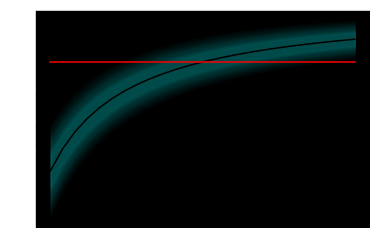

In [29]:
"""
The rate of change in tm for each % of formamide is -0.66C
30% formamide in hybe(37C) and wash(47C) means we should screen for tm above 37C+(30*0.66)= 57C
Makes sense to probe for homology all the way down to ~5bp
"""
"""
57C is at 17bp Which is likely why we screen for that. half will be below the thresh and half will be above
maybe we should go down to 15 where 84% are below 57 but the other 6% could still bind
still doesnt help with mismatches that still have high tm 
maybe a final round with more stringent 
"""
seq = ''.join(random.choice(['A','C','G','T']) for i in range(10000))
# print(seq)
nt2int = {'A':0,'C':1,'G':2,'T':3,'N':np.nan}
intSeq = np.array([nt2int[i] for i in seq])
monovalentSalt=0.3
seedLength=17
probeConc=5e-9
HT = [0,-7.6,-8.4,-7.8,-7.2,
      -8.5,-8.0,-10.6,-7.8,
      -8.2,-9.8,-8.0,-8.4,
      -7.2,-8.2,-8.5,-7.6]
ST = [0,-21.3,-22.4,-21.0,-20.4,
      -22.7,-19.9,-27.2,-21.0,
      -22.2,-24.4,-19.9,-22.4,
      -21.3,-22.2,-22.7,-21.3]
x = np.array([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30])
mu = np.empty(len(x))
std = np.empty(len(x))
for i,probe_len in enumerate(x):
    hashBase = [4**i for i in np.linspace(probe_len-1,0,probe_len)]
    nnID = (4*intSeq[:-1] + intSeq[1:])+1 # convert seq to pairs
    nnID = np.nan_to_num(nnID).astype(int) # N to 0
    # Calculate Free energy
    dG = np.zeros([2,len(seq)-1])
    dG[0,:] = np.array([HT[i] for i in nnID])
    dG[1,:] = np.array([ST[i] for i in nnID])
    # Calculate Entropy and Enthalpy
    H = lfilter(np.ones([probe_len]),1,dG[0,:])[probe_len-1:]
    S = lfilter(np.ones([probe_len]),1,dG[1,:])[probe_len-1:]
    fivePrimeAT = (1*(intSeq==0)+1*(intSeq==3))[:-(probe_len)]
    threePrimeAT = (1*(intSeq==0)+1*(intSeq==3))[probe_len:]
    H = H+0.2+(2.2*fivePrimeAT)+(2.2*threePrimeAT)
    S = S-5.7+(6.9*fivePrimeAT)+(6.9*threePrimeAT)
    S = S + 0.368*(probe_len-1)*np.log(monovalentSalt)
    # Calcuate Melting Temp for 30 bp probes
    tm = (H*1000)/(S+1.9872*np.log(probeConc))-273.15
    mu[i] = np.mean(tm)
    std[i] = np.std(tm)
plt.plot(x,mu,c='k')
c = np.linspace(1,3,num=20)
for i in c:
    plt.fill_between(x,mu-(i*std), mu+(i*std),alpha=1/(i*len(c)),color='c')
plt.plot([x.min(),x.max()],[57,57],c='r')
plt.show()

In [30]:
def generateHashLookup(partial_transcriptome):
    vector = np.concatenate(list(partial_transcriptome['hash']))
    expression_vector = np.concatenate(list(partial_transcriptome['expression_vector']))
    array = np.concatenate((vector[:,None],expression_vector[:,None]),axis=1)
    lookup = {}
    for h in np.unique(vector):
        lookup[h] = 0
    for h,c in array:
         lookup[h] =  lookup[h]+c
    return lookup

def generateProbeScores(gene_transcriptome,background_lookup,
                        probe_len=30,
                        monovalentSalt=0.3,
                        seedLength=17,
                        probeConc=5e-9,
                        nt2int = {'A':0,'C':1,'G':2,'T':3,'N':np.nan},
                        HT = [0,-7.6,-8.4,-7.8,-7.2,
                              -8.5,-8.0,-10.6,-7.8,
                              -8.2,-9.8,-8.0,-8.4,
                              -7.2,-8.2,-8.5,-7.6],
                        ST = [0,-21.3,-22.4,-21.0,-20.4,
                              -22.7,-19.9,-27.2,-21.0,
                              -22.2,-24.4,-19.9,-22.4,
                              -21.3,-22.2,-22.7,-21.3],
                        tm_max = 76,
                        tm_min = 66,
                        GC_max = 63/100,
                        GC_min = 43/100):
    
    out = []
    gene_lookup = generateHashLookup(gene_transcriptome)
    hashBase = [4**i for i in np.linspace(probe_len-1,0,probe_len)]
    for idx,row in gene_transcriptome.iterrows():
        seq = row['seq']
        gene = row['gene']
        seed_hash = row['hash']
        intSeq = row['intseq']
        background_score  = [background_lookup[sh]-gene_lookup[sh] for sh in seed_hash]
        gene_score  = [gene_lookup[sh] for sh in seed_hash]
        h = lfilter(hashBase,1,intSeq)[probe_len-1:-1].astype(int)
        nnID = (4*intSeq[:-1] + intSeq[1:])+1 # convert seq to pairs
        nnID = np.nan_to_num(nnID).astype(int) # N to 0
        # Calculate Free energy
        dG = np.zeros([2,len(seq)-1])
        dG[0,:] = np.array([HT[i] for i in nnID])
        dG[1,:] = np.array([ST[i] for i in nnID])
        # Calculate Entropy and Enthalpy
        H = lfilter(np.ones([probe_len]),1,dG[0,:])[probe_len-1:]
        S = lfilter(np.ones([probe_len]),1,dG[1,:])[probe_len-1:]
        fivePrimeAT = (1*(intSeq==0)+1*(intSeq==3))[:-(probe_len)]
        threePrimeAT = (1*(intSeq==0)+1*(intSeq==3))[probe_len:]
        H = H+0.2+(2.2*fivePrimeAT)+(2.2*threePrimeAT)
        S = S-5.7+(6.9*fivePrimeAT)+(6.9*threePrimeAT)
        S = S + 0.368*(probe_len-1)*np.log(monovalentSalt)
        # Calcuate Melting Temp for 30 bp probes
        tm = (H*1000)/(S+1.9872*np.log(probeConc))-273.15
        # Calculate GC content for 30 bp probes
        gc = 1*((intSeq==1)|(intSeq==2))
        gc = lfilter(np.ones([probe_len])/probe_len,1,gc)[probe_len-1:-1]
        p_mask = 1*(((1*(tm>tm_max))+(1*(tm<tm_min))+(1*(gc>GC_max))+(1*(gc<GC_min)))==0)
        values = [seq,gene,seed_hash,intSeq,h,tm,gc,p_mask,background_score,gene_score]
        idx_df = pd.DataFrame(values,columns=[idx],index=['seq','gene','seed_hash','intSeq','hash','tm','gc','p_mask','background_score','gene_score']).T
        out.append(idx_df)
    return pd.concat(out)
# Input = []
# for gene in tqdm.tqdm(target_transcriptome.gene.unique(),desc='Generating Input',leave=False):
#     gene_transcriptome = target_transcriptome[target_transcriptome.gene==gene].copy()
#     Input.append(gene_transcriptome)

# sys.stdout.flush()
# pfunc = partial(generateProbeScores,background_lookup=background_lookup)
# gene_transcriptome_dict = {}
# with Pool(30) as p:
#     for gene_transcriptome_processed in tqdm.tqdm(p.imap(pfunc,Input),total=len(Input),desc='Outer'):
#         gene = gene_transcriptome_processed.gene.iloc[0]
#         gene_transcriptome_dict[gene] = gene_transcriptome_processed
# sys.stdout.flush()


In [41]:
"""
Find All passing probes that are a certain overlap apart
"""
for gene in random.sample(list(target_transcriptome.gene.unique()),100):
    probe_len = 30
    gene_transcriptome = target_transcriptome[target_transcriptome.gene==gene]
    gene_transcriptome_processed = generateProbeScores(gene_transcriptome,background_lookup)
    p_mask = np.array(gene_transcriptome_processed['p_mask'].iloc[0])
    background_score = np.array(gene_transcriptome_processed['background_score'].iloc[0])
    p_score = np.array([np.sum(background_score[i:i+probe_len]) for i in range(len(p_mask))])
    thresh = 0
    overlap = 15
    probes = []
    for i,p in enumerate(p_mask):
        if p==1:
            if p_score[i]<=thresh:
                if len(set(list(range(i-30+overlap,i+30-overlap))).intersection(probes))==0:
                    probes.append(i)
    # print(len(probes))
    thresh = thresh+10
    for i,p in enumerate(p_mask):
        if p==1:
            if p_score[i]<=thresh:
                if len(set(list(range(i-30+overlap,i+30-overlap))).intersection(probes))==0:
                    probes.append(i)
    print(gene,len(probes))

Tnfrsf25 30
Lamc2 167
Bmp2 85
Tm6sf1 0
Clasp2 105
Actl6b 28
Ttc9b 55
Rxrb 28
Clns1a 38
Rps19 0
Snrpg 17
Ndst3 0
Adhfe1 37
Car2 35
Atp5k 1
Ppp2r5d 91
Zfand6 14
Cotl1 33
Cox17 2
Gabbr1 28
Fam19a2 9
Calcoco1 59
Trappc10 145
Clybl 51
Acsl3 55
Abhd6 73
Rora 84
H3f3b 21
Pcbp2 97
Sema6c 4
Lamtor1 37
Chst10 163
Crk 103
Fam188a 0
Bdnf 108
Acot1 12
Glrx3 30
Igfn1 95
Hax1 0
Fbxw11 130
Cyr61 66
Myo5b 61
Impa1 116
Cdkl5 103
Wif1 27
Igsf3 234
Gnb2 9
Rab11fip4 16
Rogdi 0
Ap2m1 31
Fam212b 178
Csdc2 8
Otub1 36
L3mbtl2 15
Msln 79
Copz2 7
Epdr1 61
Atpaf1 8
Hint2 0
Fstl5 68
Asah1 23
Slc7a14 116
Rnf220 12
Tdo2 38
1500011B03Rik 46
Spsb4 0
Tspan17 15
Dclk2 4
Scx 15
Usp9x 240
Arr3 2
Pptc7 66
Smad1 38
Ndufs5 13
Lancl3 98
Sidt1 46
Polb 13
Sipa1l3 2
Arpc5l 0
Acsl4 108
Rtn4rl1 84
Tbr1 88
Hook1 12
Efna3 58
Ano8 75
Hnrnpc 84
Lrrk2 148
Psmc2 57
Pja2 144
Pde4b 107
Dcaf6 91
Alkbh8 61
Rnf26 0
1810037I17Rik 26
Pparg 42
Stard10 15
Gas7 53
Prrt3 66
Ddx1 92
Arpp21 32


In [22]:
np.array(background_score)[np.array(probes)]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
gene_score = gene_transcriptome_processed['gene_score'].iloc[0]
np.array(gene_score)[np.array(probes)]

array([4.53013149, 4.53013149, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026298,
       9.06026298, 9.06026298, 9.06026298, 9.06026298, 9.06026

In [24]:
gene_transcriptome_processed

,seq,gene,seed_hash,intSeq,hash,tm,gc,p_mask,background_score,gene_score
ENSMUST00000109280,ATGCTATTGAATCAAACAGAAGAAGAGGCCAGTGATTGTGAGAATC...,Pwwp2a,"[4324520812, 1081130203, 8860217142, 221505428...","[0, 3, 2, 1, 3, 0, 3, 3, 2, 0, 0, 3, 1, 0, 0, ...","[405895854273262464, 101473963568315616, 60182...","[67.56977831708917, 67.91869496224194, 67.9220...","[0.39999999999999997, 0.39999999999999997, 0.4...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.53013149020025, 4.53013149020025, 4.5301314..."
ENSMUST00000061070,GTTAGCGGGAGGGAGGGGAAGGCCTCGGGATCCCAGCCGCGCTGCC...,Pwwp2a,"[11318502974, 11419560335, 2854890083, 7137225...","[2, 3, 3, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, ...","[191220510911276608, 912496256182954368, 51635...","[78.79240988069893, 78.60571212548945, 79.8938...","[0.7, 0.6666666666666666, 0.7, 0.7333333333333...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.53013149020025, 4.53013149020025, 4.5301314..."


In [27]:
seq = gene_transcriptome_processed['seq'].iloc[0]
start = probes[0]
end = start+probe_len
probe_seq = seq[start:end]
print(probe_seq)
print(gene_transcriptome_processed['gc'].iloc[0][start])
print(gene_transcriptome_processed['tm'].iloc[0][start])
print(gene_transcriptome_processed['background_score'].iloc[0][start])
print(gene_transcriptome_processed['gene_score'].iloc[0][start])

CTGCAAAAGAAAGGTGCAAAAAGGTTTGGG
0.4333333333333333
70.71254248499565
0.0
4.53013149020025


In [ ]:
import os
import pandas as pd
from scipy import sparse
base = '/bigstore/binfo/mouse/Hippocampus/Allen/'
raw_counts = []
cells = []
genes  = []
for f in os.listdir(base):
    print(f)
    if f.split('.')[-1] =='gz':
        temp = pd.read_csv(os.path.join(base,f))
        cells.extend(temp.columns)
        genes.append(temp.index)
        raw_counts.append(sparse.csr_matrix(temp))
        del temp
rc = np.concatenate([A.A for A in raw_counts],axis=1)
rc = pd.DataFrame(rc,index=genes[0],columns=cells)
rc.to_csv(os.path.join(base,'raw_counts.csv'))
del rc
del raw_counts

Allen_1:10000.csv.gz


In [39]:
rc.to_csv(os.path.join(base,'raw_counts.csv'))

In [41]:
del rc
del raw_counts

NameError: name 'rc' is not defined